# Downloading Data
To download data from yfinance, uncomment and run the following cell. This downloads the past 60 days of data from the first 100 tech stocks listed on https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/ and saves it in a folder called `yf_data`. Make sure to run this notebook from the root directory.


In [1]:
# # load and store data
# !python3 atgym/atdata/data_loader.py

# Imports
The library atgym provides a data loader class and an OpenAI-stle trading environment. We use these to train and evaluate strategies.

A short description of the strategies:

Conventional
- SMAStrategy: uses simple moving average as momentum indicator that can trigger buy/sell actions
- WMAStrategy: like SMAStrategy, but uses a linearly weighted moving average
- EMAStrategy: like SMAStrategy, but uses an exponentially weighted moving average
- EngulfingStrategy: goal is to detect and capitalize on trend reversals
- RSIStrategy: uses relative strength index to determine overbought/underbought conditions

Reinforcement-Learning-Based
- DQNStrategy: periodically updates a neural network that approximates the target network
- A2CStrategy: uses an advantage actor-critic model where the actor executes the policy and the critic evaluates the taken action
- PPO: proximal-policy optimization, can also use actor-critic model but is distinct for its use of ratio clipping that prevents large, detrimental gradient updates to the network

In [1]:
from atgym.atdata import TradingDataLoader
from atgym.atsim import TradingEnv
from atgym.atstrategies import (
    SMAStrategy,
    WMAStrategy,
    EMAStrategy,
    EngulfingStrategy,
    RSIStrategy,
    A2CStrategy,
    DQNStrategy,
    PPOStrategy
)

# Loading Data

In [2]:
# load data using the TradingDataLoader class
tdl = TradingDataLoader()
tdl.load_data()

# split data into train and test
train_data, test_data = tdl.train_test_split(train_size=None, test_size=0.2,
                         split_by_time=True, random_state=42)

In [3]:
train_env = TradingEnv(train_data, trading_cost_pct=0.0)
test_env = TradingEnv(test_data, trading_cost_pct=0.0)

In [4]:
obs_shape = train_env.reset().shape
print(obs_shape)

(20, 4)


# Conventional Strategies

## Moving-Average-Based Strategies

In [21]:
import numpy as np

def visualize_strategy(strategy):
    np.random.seed(44)

    state = test_env.reset()
    rewards = []
    while True:
        action = strategy.predict(state)
        state, reward, done, info = test_env.step(action)

        rewards.append(reward)
        if done:
            test_env.render()
            break
    print("total reward: ", sum(rewards))

In [7]:
sma = SMAStrategy(obs_shape=obs_shape)
wma = WMAStrategy(obs_shape=obs_shape)
ema = EMAStrategy(obs_shape=obs_shape)

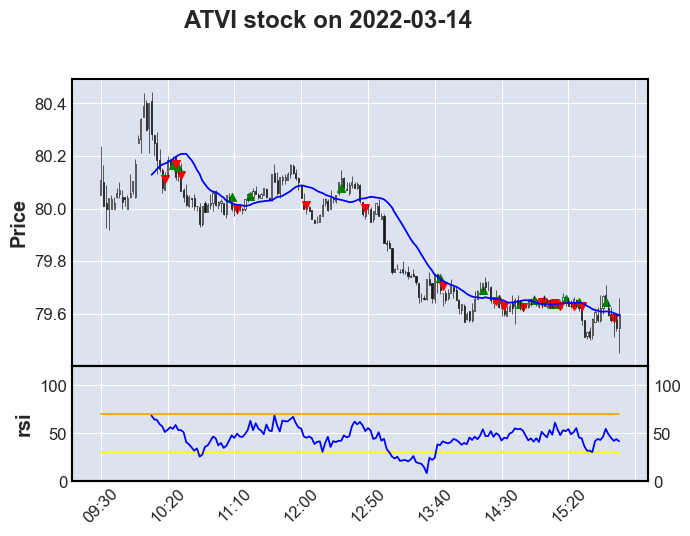

total reward:  0.0015121068622204747


In [8]:
visualize_strategy(sma)

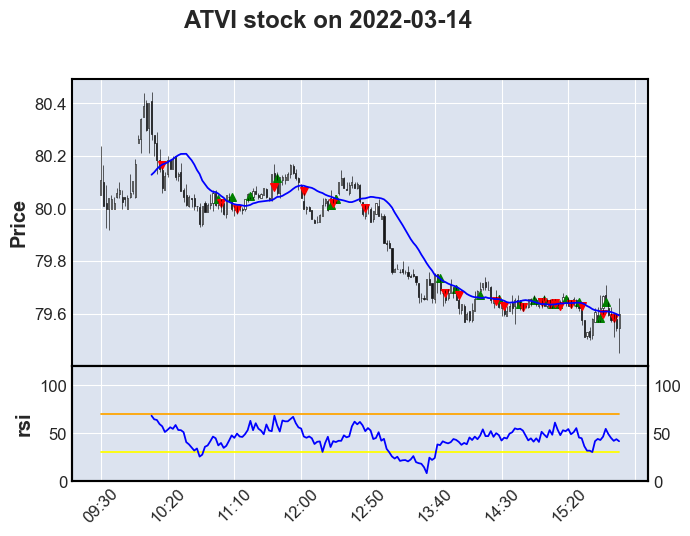

total reward:  0.003074869852351836


In [9]:
visualize_strategy(wma)

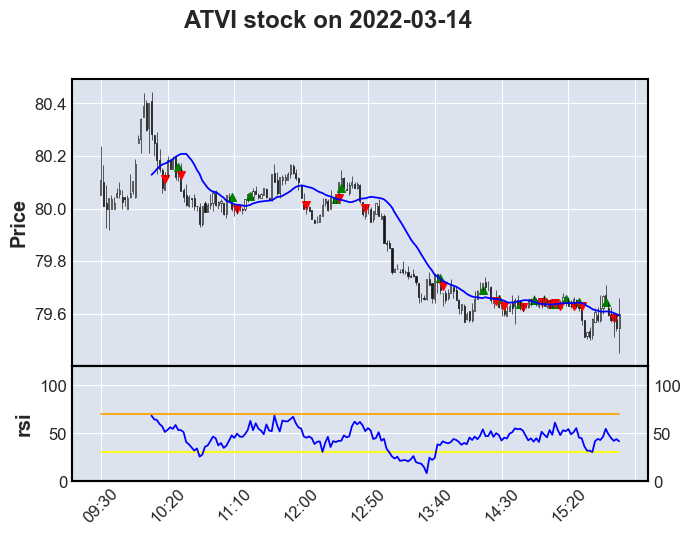

total reward:  0.0015120592082898954


In [10]:
visualize_strategy(ema)

# Engulfing Strategy

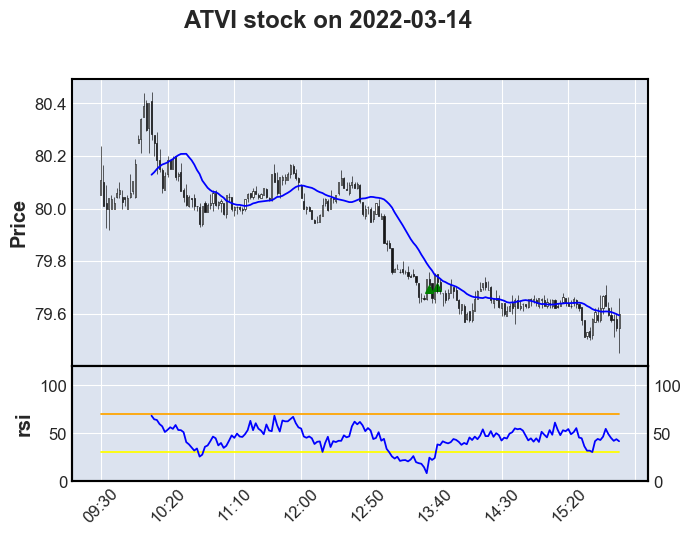

total reward:  -0.0031230956298105017


In [11]:
engulf = EngulfingStrategy(obs_shape=obs_shape)
visualize_strategy(engulf)

## Relative Strength Index Strategy

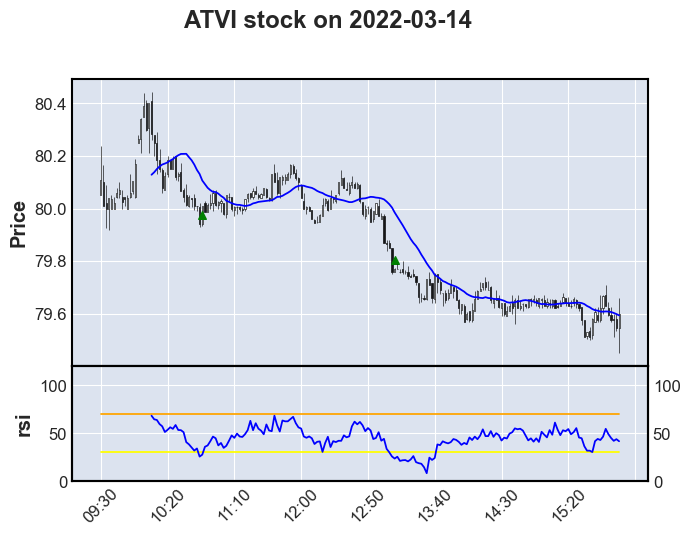

total reward:  -0.007916985709730096


In [12]:
rsi = RSIStrategy(obs_shape=obs_shape)
visualize_strategy(rsi)

## Performance of Implementations of Conventional Strategies

In [72]:
sma_error = test_env.evaluate(sma, normalized=True)

evaluating sma_strategy_0...
        SQ: 0.006372395453979866
     MPNGF
      SNOW: -0.002648134340758409
      SNPS: 0.0001452786102330942
        JD: -0.008542142801247469
      BABA: -0.009785631730611422
      CRWD: -0.0063319219651671865
      CDNS: 0.0026610167819846784
       CRM: -0.004201546794883752
     TCEHY: -0.002132479143834552
       ADP: 0.0004239815643187206
      AVGO: -0.002670488924555625
       IBM: 0.0064381331690676795
       GPN: -0.00026702848144449787
        SE: 0.00958163203827204
       NOW: -0.01771109737947074
      ADSK: -0.003463302765357279
      INTU: -0.004730011842422666
    CSU.TO
 005930.KS: -0.010937439065946816
      ATVI: -0.0012184372581085141
    IFX.DE: -0.0017016417277178435
      NXPI: -0.008542662022677209
      CSCO: 0.0028770344723018835
      MCHP: -0.002590766682043888
      EQIX: -0.0028966847022291096
       ADI: -0.0067147050230873155
   2454.TW: 0.007428744963056566
      INTC: -0.00396675128050189
 035420.KS: -3.185389034767357

In [73]:
wma_error = test_env.evaluate(wma, normalized=True, verbose=False)

In [74]:
ema_error = test_env.evaluate(ema, normalized=True, verbose=False)

In [75]:
print(sma_error, wma_error, ema_error)

-0.004660632360880294 -0.0050770696176938804 -0.004679750618269039


In [77]:
engulf_error = test_env.evaluate(engulf, normalized=True, verbose=False)

In [78]:
rsi_error = test_env.evaluate(rsi, normalized=True, verbose=False)

/Users/victorli/Documents/Code/Python Projects/atgym/atgym/atutils/compute_indicators.py:47: RuntimeWarning: invalid value encountered in double_scalars
  ratio = avg_gain / avg_loss


In [79]:
print(engulf_error, rsi_error)

-0.0006599791873665323 -0.0041040643877393755


### Summary
On the whole, the implementations of the conventional algorithms did not perform very well. In each case, while the normalized loss was minimal, these were not winning strategies. This may be due to the fact that they are often over-used, do not take into account anything other than the prices of the look-back period, and too simple of an implementation. It seems like the engulfing strategy did the best in terms of minimizing losses; however, this may be due to the fact that it is triggered less often than the other algorithms.

# Reinforcement Learning Strategies

## DQN
Deep Q-Network, which approximates a value function with a neural network and selects actions based on what maximizes the sum of reward and value of the next state. Used to achieve human-level performance on Atari games and is the basis for many other current RL algorithms.

## A2C

Actor-critic model, which approximates the advantage of an action compared to other actions that can be taken at a given state, has one model that tells what action to take and another that outputs the value of the state.

## PPO

An improvement made to the A2C model that uses a clipped objective to prevent large changes in the parameters. Has improved the state-of-the-art on continuous control problems on MuJoCo tasks and Atari games.

In [17]:
dqn = DQNStrategy(obs_shape=obs_shape, env=train_env)
a2c = A2CStrategy(obs_shape=obs_shape, env=train_env)
ppo = PPOStrategy(obs_shape=obs_shape, env=train_env)

In [18]:
# train strategies, periodically testing the reward on test set
def test_env_returns(strategy, timesteps=100000):
    print("training...")
    strategy.train(timesteps)
    train_norm_return = train_env.evaluate(strategy, normalized=True, verbose=True)
    test_norm_return = test_env.evaluate(strategy, normalized=True, verbose=True)
    print("  train normalized returns: ", train_norm_return)
    print("   test normalized returns: ", test_norm_return)
    return train_norm_return, test_norm_return

In [19]:
print('----- dqn -----')
dqn_return = test_env_returns(dqn)
print('----- a2c -----')
a2c_return = test_env_returns(a2c)
print('----- ppo -----')
ppo_return = test_env_returns(ppo)

----- dqn -----
training...
evaluating dqn_strategy_2...
        SQ: -0.16491210842318715
     MPNGF
      SNOW: -0.37407410938258245
      SNPS: 0.13140982817904923
        JD: 0.23177089696313743
      BABA: 0.14211634337936874
      CRWD: -0.17777982769422668
      CDNS: 0.06949748255301971
       CRM: 0.12677433546335973
     TCEHY: 0.12131041067435543
       ADP: 0.12769245770945212
      AVGO: 0.06493319855972278
       IBM: 0.13727725580021663
       GPN: 0.09806968036561949
        SE: 0.01299367116204335
       NOW: 0.02819144814471294
      ADSK: -0.30814486809896696
      INTU: -0.25892681546281965
    CSU.TO: 0.0447208621816344
 005930.KS: -0.015915816460024348
      ATVI: 0.08229024837249481
    IFX.DE: -0.4649584520191899
      NXPI: 0.10158721748425874
      CSCO: 0.07487251013273627
      MCHP: 0.2093140979149521
      EQIX: 0.12455264741591066
       ADI: 0.0746388286578826
   2454.TW: 0.011075965758848269
      INTC: 0.43270331255635913
 035420.KS: 0.10461482890703369

      PYPL: -0.3110253264476594
      NTES: 0.32273281090573286
     XIACF
     MRAAF
       PDD: -0.07429254080676839
       VMW: 0.18877541111822788
    MKN2.F
       AMD: 0.013832347053626867
        FB: -0.02812016422766377
     TOELF
      DASH: -0.13421821287771832
      DDOG: 0.13199016338571015
      FTNT: 0.3183142191919288
      CPNG: 0.5693853696754414
        EA: -0.05540352647397989
      SHOP: 0.04040163145625515
      TEAM: -0.26985126683042737
        ZM: -0.3125258509106669
     DASTF
       STM: 0.16777706186460217
       SAP: -0.013144943533231097
      ANET: 0.16546122573650365
      BKNG: -0.23843131561061434
   2317.TW: -0.040142326473604155
     NTDOF
      FISV: 0.23943308224364432
       TEL: -0.026478945963532396
      ASML: 0.22555843507773135
       TXN: 0.21225566297468706
      SNAP: 0.09269833382575038
     KYCCF: -0.028169703763687437
     SBGSF
      KLAC: -0.10327113612776496
      BIDU: 0.2106631730658577
      NFLX: 0.25235517340491737
      SONY: 0.

 035420.KS: -0.10561452000114417
      LRCX: -0.19771278350034885
      ALGN: -0.2769958814194631
      MELI: -0.8091617084466071
       TSM: -0.07148569531380507
        MU: -0.3236296351673869
     ADYYF
      PANW: -0.31593830924138544
       FIS: -0.28886190320648747
      ABNB: -0.4627162223943664
      AMZN: -0.07920163932099437
      ORCL: -0.14905746833288921
 000660.KS: 0.04592563680421987
       ROP: -0.015495564431531031
      EBAY: 0.24378531821827565
      MRVL: -0.1965698981396121
      TSLA: -0.32912874015358895
       IQV: 0.0808848381186363
 035720.KS: -0.16263566720383693
      COIN: -0.2556300105907224
      UBER: -0.10205160899793124
   1024.HK: 0.4244238257969292
      AMAT: -0.12571683774395245
       HPQ: -0.09592167447701883
       GFS: -0.5882631246793526
      NVDA: -0.18557062283876982
      DELL: -0.004547379408093614
      WDAY: -0.11845875174793719
      GOOG: -0.0947197425237422
      AAPL: -0.19269052627143304
       TTD: 0.06747432383337919
      MSFT: 

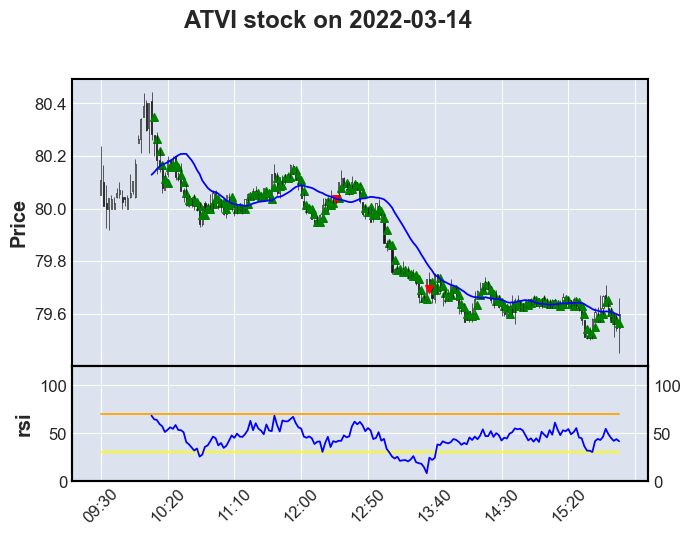

total reward:  -0.6018292056452879


In [22]:
visualize_strategy(dqn)

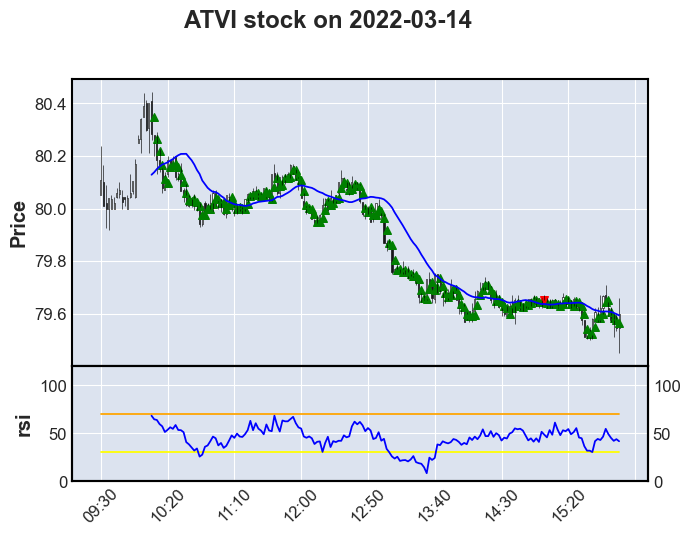

total reward:  -0.6210672879215053


In [23]:
visualize_strategy(a2c)

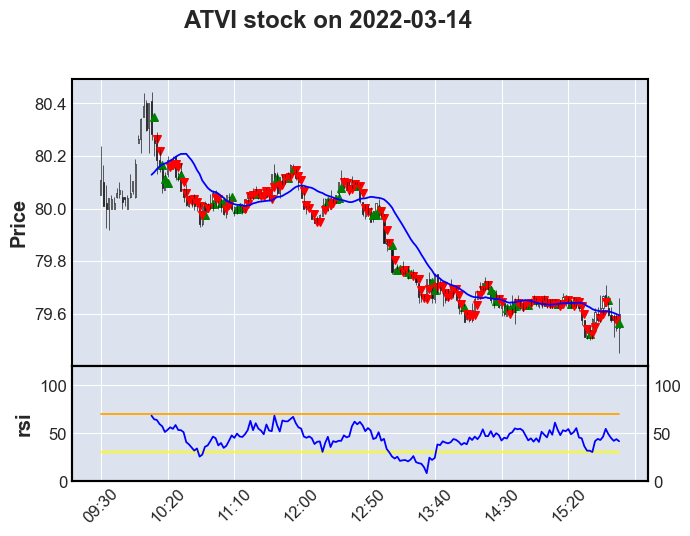

total reward:  0.2236711082036038


In [24]:
visualize_strategy(ppo)

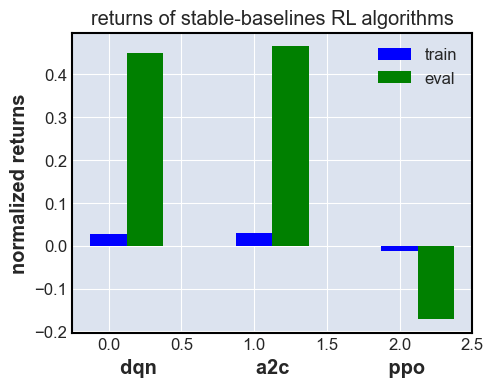

In [47]:
import matplotlib.pyplot as plt

results = [[dqn_return[0], a2c_return[0], ppo_return[0],],
    [dqn_return[1], a2c_return[1], ppo_return[1],]
]

X = np.arange(3)
fig = plt.figure(figsize=(4,3))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, results[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, results[1], color = 'g', width = 0.25)
ax.set_xlabel(f'dqn                  a2c                  ppo')
ax.set_ylabel('normalized returns')
ax.set_title('returns of stable-baselines RL algorithms')
ax.legend(labels=['train', 'eval'])

### Summary

The stable-baselines implementation of dqn, a2c, and ppo, after being trained, buy and sell a lot more than compared to the conventional strategies. They seem to be quite risky, as their normalized returns are much higher than the conventional strategies, with possibilities of bad losses as can be seen in the PPO algorithm. Currently, they are not very successful in picking up on local patterns that could generate returns. Furthermore, they are currently being trained on an interval of data (first part of past 60 days) that is highly related to the interval of data being tested on (last part of past 60 days). Further study in optimizing the amount of training, designing the observation space of the input (currently quite large, with 20 look-back steps x 4 for Open, High, Low, Close), data cleaning, introducing other analyses on the traded security, and tuning hyperparameters may yield useful results in the application of reinforcement learning in trading.